In [51]:
import numpy as np
import os
import torch
import torch.nn as nn
import time
import pandas as pd
from scipy.stats import pearsonr

In [52]:
from model.util import Normalizer
from model.database_util import get_hist_file, get_job_table_sample, collator
from model.model import QueryFormer
from model.database_util import Encoding
from model.dataset import PlanTreeDataset
from model.trainer import eval_workload, train

In [53]:
data_path = './data/imdb/'

In [54]:
class Args:
    bs = 128  # Batch size for training (number of samples per batch).
    lr = 0.001  # Learning rate controlling weight updates.
    epochs = 100  # Number of times the model trains on the entire dataset.
    clip_size = 50  # Gradient clipping to prevent exploding gradients.
    embed_size = 64  # Size of embedding vectors for input features.
    pred_hid = 128  # Number of hidden units in the prediction layer.
    ffn_dim = 128  # Size of the feed-forward network layer.
    head_size = 12  # Number of attention heads in the model.
    n_layers = 8  # Number of layers in the model.
    dropout = 0.1  # Dropout rate to prevent overfitting.
    sch_decay = 0.6  # Learning rate scheduler decay factor.
    device = 'cuda:0'  # Device for computation (GPU if available).
    newpath = './results/full/knobs_and_cost/'  # Path to save results.
    to_predict = 'both'  # Specifies the prediction target ('cost', 'knobs', or 'both').
    knob_column = 'Node Type'  # Column name representing the knob type.

args = Args()

# Ensure the results directory exists
import os
if not os.path.exists(args.newpath):
    os.makedirs(args.newpath)  # Creates the directory if it doesn't exist.


In [55]:
# Load the histogram file
hist_file = get_hist_file(data_path + 'histogram_string.csv')
# Normalizer for cost
cost_norm = Normalizer(-3.61192, 12.290855)
# Normalizer for cardinality
card_norm = Normalizer(1, 100)
# Normalizer for knob settings (if applicable)
knob_norm = Normalizer(0, 1)  # Adjust ranges based on your knob setting values


e:\KHU\Research\QueryFormer\QueryFormer\model\database_util.py:76: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hist_file['freq'][i] = freq_np
e:\KHU\Research\QueryFormer\QueryFormer\model\database_util.py:89: FutureWarning: ChainedAssignme

In [56]:
encoding_ckpt = torch.load('checkpoints/encoding.pt')  # Loads the saved encoding checkpoint from a file.
encoding = encoding_ckpt['encoding']  # Extracts the 'encoding' object from the checkpoint.
checkpoint = torch.load('checkpoints/cost_model.pt', map_location='cpu')  # Loads the saved cost model checkpoint and maps it to CPU.


C:\Users\Hashmi\AppData\Local\Temp\ipykernel_9220\146086392.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoding_ckpt = torch.load('checkpoints/encoding.pt')  # Load

In [57]:
if torch.cuda.is_available():
    x = torch.randn(3, 3).cuda()
    print(x)
else:
    print("CUDA is not available")

tensor([[-0.2664, -1.0967,  0.4952],
        [ 0.0334, -0.2384, -0.7239],
        [-1.3295, -0.4821,  0.2420]], device='cuda:0')


In [58]:
imdb_path = './data/imdb/'
dfs = []  # list to hold DataFrames
# SQ: added
for i in range(1):
#for i in range(18):
    file = imdb_path + 'plan_and_cost/tradata.csv'.format(i)
    # file = imdb_path + 'plan_and_cost/train_plan_part{}.csv'.format(i)
    df = pd.read_csv(file)
    dfs.append(df)

full_train_df = pd.concat(dfs)

# val_dfs = []  # list to hold DataFrames
# for i in range(18,20):
#     file = imdb_path + 'plan_and_cost/val_plans.csv'.format(i)
#     # file = imdb_path + 'plan_and_cost/train_plan_part{}.csv'.format(i)
#     df = pd.read_csv(file)
#     val_dfs.append(df)

# val_df = pd.concat(val_dfs)

In [59]:
print(full_train_df.head())


   id                                               json
0   0  {"Plan": {"Node Type": "Gather", "Parallel Awa...
1   1  {"Plan": {"Node Type": "Seq Scan", "Parallel A...
2   2  {"Plan": {"Node Type": "Seq Scan", "Parallel A...
3   3  {"Plan": {"Node Type": "Gather", "Parallel Awa...
4   4  {"Plan": {"Node Type": "Bitmap Heap Scan", "Pa...


In [60]:
import json

# Parse JSON in the 'json' column
full_train_df["json"] = full_train_df["json"].apply(json.loads)  # Convert JSON string to dict
# val_df["json"] = val_df["json"].apply(json.loads)  # Convert JSON string to dict


In [61]:
full_train_df

,id,json
0,0,"{'Plan': {'Node Type': 'Gather', 'Parallel Awa..."
1,1,"{'Plan': {'Node Type': 'Seq Scan', 'Parallel A..."
2,2,"{'Plan': {'Node Type': 'Seq Scan', 'Parallel A..."
3,3,"{'Plan': {'Node Type': 'Gather', 'Parallel Awa..."
4,4,"{'Plan': {'Node Type': 'Bitmap Heap Scan', 'Pa..."
...,...,...
1196,1196,"{'Plan': {'Node Type': 'Gather', 'Parallel Awa..."
1197,1197,"{'Plan': {'Node Type': 'Hash Join', 'Parallel ..."
1198,1198,"{'Plan': {'Node Type': 'Hash Join', 'Parallel ..."
1199,1199,"{'Plan': {'Node Type': 'Gather', 'Parallel Awa..."


In [62]:
full_train_df["Plan"] = full_train_df["json"].apply(lambda x: x.get("Plan", {}))
# val_df["Plan"] = val_df["json"].apply(lambda x: x.get("Plan", {}))


In [63]:
full_train_df["Total Cost"] = full_train_df["Plan"].apply(lambda x: x.get("Total Cost", None))


In [64]:
full_train_df

,id,json,Plan,Total Cost
0,0,"{'Plan': {'Node Type': 'Gather', 'Parallel Awa...","{'Node Type': 'Gather', 'Parallel Aware': Fals...",154548.95
1,1,"{'Plan': {'Node Type': 'Seq Scan', 'Parallel A...","{'Node Type': 'Seq Scan', 'Parallel Aware': Fa...",67602.30
2,2,"{'Plan': {'Node Type': 'Seq Scan', 'Parallel A...","{'Node Type': 'Seq Scan', 'Parallel Aware': Fa...",347461.15
3,3,"{'Plan': {'Node Type': 'Gather', 'Parallel Awa...","{'Node Type': 'Gather', 'Parallel Aware': Fals...",87837.10
4,4,"{'Plan': {'Node Type': 'Bitmap Heap Scan', 'Pa...","{'Node Type': 'Bitmap Heap Scan', 'Parallel Aw...",25968.71
...,...,...,...,...
1196,1196,"{'Plan': {'Node Type': 'Gather', 'Parallel Awa...","{'Node Type': 'Gather', 'Parallel Aware': Fals...",128420.85
1197,1197,"{'Plan': {'Node Type': 'Hash Join', 'Parallel ...","{'Node Type': 'Hash Join', 'Parallel Aware': F...",191323.98
1198,1198,"{'Plan': {'Node Type': 'Hash Join', 'Parallel ...","{'Node Type': 'Hash Join', 'Parallel Aware': F...",1056695.23
1199,1199,"{'Plan': {'Node Type': 'Gather', 'Parallel Awa...","{'Node Type': 'Gather', 'Parallel Aware': Fals...",444395.56


In [65]:
print(full_train_df["Plan"].apply(lambda x: x.get("Execution Time")).dropna().tolist())


[]


In [66]:
import numpy as np

def extract_knob_settings_from_plan(plan):
    """
    Extracts relevant knob settings from a PostgreSQL execution plan.

    Args:
        plan (dict): A query execution plan in dictionary format.

    Returns:
        dict: Extracted knob settings.
    """
    if not plan:  # Handle empty or missing plans
        return {}

    # Extract key execution parameters
    knobs = {
        "Node Type": plan.get("Node Type", "NA"),
        "Parallel Aware": plan.get("Parallel Aware", np.nan),
        "Workers Planned": plan.get("Workers Planned", np.nan),
        
        # Execution knobs
        "Enable Seq Scan": "Seq Scan" in plan.get("Node Type", ""),
        "Enable Hash Join": "Hash Join" in plan.get("Node Type", ""),
        "Enable Merge Join": "Merge Join" in plan.get("Node Type", ""),
        "Enable Index Scan": "Index Scan" in plan.get("Node Type", ""),
        "Enable Bitmap Scan": "Bitmap Index Scan" in plan.get("Node Type", ""),
        "Enable Nested Loop": "Nest Loop" in plan.get("Node Type", ""),
        "Enable Index Only Scan": "Index Only Scan" in plan.get("Node Type", ""),
        "Enable Gather Merge": "Gather Merge" in plan.get("Node Type", ""),
        "Enable Hash Agg": "Hash Aggregate" in plan.get("Node Type", ""),
        "Enable Parallel Append": "Parallel Append" in plan.get("Node Type", ""),
        "Enable Parallel Hash": "Parallel Hash" in plan.get("Node Type", ""),
        "Enable Partition Pruning": "Partition Pruning" in plan.get("Node Type", ""),
        "Enable Sort": "Sort" in plan.get("Node Type", ""),
        "Enable TID Scan": "Tid Scan" in plan.get("Node Type", ""),
        "Enable Material": "Materialize" in plan.get("Node Type", ""),
        
        # Additional Postgres execution settings
        "GEQO Enabled": plan.get("GEQO", False),  # Genetic Query Optimizer
        "JIT Compilation": plan.get("JIT", False),  # Just-In-Time Compilation
        "JIT Expressions": plan.get("JIT Expressions", False),
        "JIT Tuple Deforming": plan.get("JIT Tuple Deforming", False),
        "Parallel Leader Participation": plan.get("Parallel Leader Participation", False),
    }

    # If there are subplans, recursively extract settings
    if "Plans" in plan:
        for subplan in plan["Plans"]:
            sub_knobs = extract_knob_settings_from_plan(subplan)
            knobs.update(sub_knobs)

    return knobs


In [67]:
train_knob_settings = full_train_df["Plan"].apply(extract_knob_settings_from_plan)
train_knob_settings = pd.DataFrame(list(train_knob_settings))  # Convert list of dicts to DataFrame

print(train_knob_settings.head())

           Node Type  Parallel Aware  Workers Planned  Enable Seq Scan  \
0           Seq Scan            True              NaN             True   
1           Seq Scan           False              NaN             True   
2           Seq Scan           False              NaN             True   
3  Bitmap Index Scan           False              NaN            False   
4  Bitmap Index Scan           False              NaN            False   

   Enable Hash Join  Enable Merge Join  Enable Index Scan  Enable Bitmap Scan  \
0             False              False              False               False   
1             False              False              False               False   
2             False              False              False               False   
3             False              False               True                True   
4             False              False               True                True   

   Enable Nested Loop  Enable Index Only Scan  ...  Enable Parallel 

In [68]:
train_knob_settings = train_knob_settings.fillna(False)


C:\Users\Hashmi\AppData\Local\Temp\ipykernel_9220\2942928849.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_knob_settings = train_knob_settings.fillna(False)


In [69]:
train_knob_settings

,Node Type,Parallel Aware,Workers Planned,Enable Seq Scan,Enable Hash Join,Enable Merge Join,Enable Index Scan,Enable Bitmap Scan,Enable Nested Loop,Enable Index Only Scan,...,Enable Parallel Hash,Enable Partition Pruning,Enable Sort,Enable TID Scan,Enable Material,GEQO Enabled,JIT Compilation,JIT Expressions,JIT Tuple Deforming,Parallel Leader Participation
0,Seq Scan,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Seq Scan,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Seq Scan,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Bitmap Index Scan,False,False,False,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Bitmap Index Scan,False,False,False,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196,Bitmap Index Scan,False,False,False,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1197,Seq Scan,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1198,Seq Scan,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1199,Seq Scan,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [70]:
full_train_df = pd.concat([full_train_df, train_knob_settings], axis=1)


In [71]:
table_sample = get_job_table_sample(imdb_path+'train')

Loaded queries with len  100000
Loaded bitmaps


In [72]:
to_predict = 'both'

In [73]:
train_ds = PlanTreeDataset(full_train_df, None, encoding, hist_file, card_norm, cost_norm, to_predict, table_sample)
# val_ds = PlanTreeDataset(val_df, None, encoding, hist_file, card_norm, cost_norm, to_predict, table_sample)

In [74]:
# Fetch the first sample from the dataset
sample, label = train_ds[0]
print(sample)  # This will show the feature data
print(label)   # This will show the corresponding target labels (cost or knobs)


{'x': tensor([[[ 0.,  0., 20.,  ...,  0.,  0.,  0.],
         [ 1.,  1., 20.,  ...,  0.,  0.,  0.],
         [ 2.,  0.,  1.,  ...,  0.,  0.,  0.],
         ...,
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.]]]), 'attn_bias': tensor([[[0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
          -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
          -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., -inf, 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
          -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., -inf, -inf, 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,

In [75]:
# Inspect the feature structure for the first sample
print(f"Feature structure of the first sample: {sample.keys()}")  # Check the keys in the sample dict

# Print the actual feature data
print(f"Features: {sample['x'][:10]}")  # Display a part of the feature data (first 10 elements)


Feature structure of the first sample: dict_keys(['x', 'attn_bias', 'rel_pos', 'heights'])
Features: tensor([[[ 0.,  0., 20.,  ...,  0.,  0.,  0.],
         [ 1.,  1., 20.,  ...,  0.,  0.,  0.],
         [ 2.,  0.,  1.,  ...,  0.,  0.,  0.],
         ...,
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  ...,  1.,  1.,  1.]]])


In [76]:
# Check dimensions of features and labels
print(f"Shape of features: {sample['x'].shape}")
print(f"Shape of attention bias: {sample['attn_bias'].shape}")
print(f"Shape of relative position: {sample['rel_pos'].shape}")


Shape of features: torch.Size([1, 30, 1165])
Shape of attention bias: torch.Size([1, 31, 31])
Shape of relative position: torch.Size([1, 30, 30])


In [77]:
# Inspect the labeli means 
print(f"Label for first sample: {label}")


Label for first sample: (tensor(0.6348, dtype=torch.float64), tensor(0.))


In [78]:
def save_train_dataset_to_csv(train_ds, filename):
    rows = []

    for i in range(len(train_ds)):
        # Extract collated_dicts and labels
        features, (cost_label, hint_label) = train_ds[i]
        
        # Flatten features for easier CSV representation
        features_flattened = {f"feature_{j}": value for j, value in enumerate(features['x'].flatten().numpy())}
        
        # Add cost and card labels
        features_flattened['cost_label'] = cost_label.item()
        # features_flattened['card_label'] = card_label.item()
        features_flattened['hint_label'] = hint_label.item()
        
        
        rows.append(features_flattened)
    
    # Create DataFrame
    df = pd.DataFrame(rows)
    # 
    # Save to CSV
    df.to_csv(filename, index=False)
    print(f"Training dataset saved to {filename}")

In [79]:
train_ds.knob_labels

tensor([0., 2., 2.,  ..., 1., 0., 0.])

In [80]:
# save_train_dataset_to_csv(train_ds, "out/trian2_dataset.csv")
# save_train_dataset_to_csv(train_ds, "out/trian2_dataset.csv")

SVM for classification

In [81]:
print(df.isnull().sum().sum())  # Total number of missing values


0


In [82]:
print(df.shape)  # Should match expected number of samples and features
print(df.columns[:10])  # Print first 10 columns to confirm naming


(999, 2)
Index(['id', 'json'], dtype='object')


In [83]:
# print(df.describe())  # Check min/max values for unexpected values


In [84]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score


In [85]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier


def read_csv(file_path):
    data = pd.read_csv(file_path)
    return data

def extract_features_labels(data, label_column):
    X = data.drop(columns=[label_column])  # Features
    y = data[label_column]                 # Labels
    return X, y

def train_svm(X_train, y_train):
    svm = SVC(C=0.1, kernel='linear', class_weight='balanced', random_state=42)
    svm.fit(X_train, y_train)
    return svm

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    return accuracy, precision, recall

def preprocess_features(X):
    # Standardize features for SVM (if numerical)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

# Train Gradient Boosting Classifier
def train_gradient_boosting(X_train, y_train):
    gbc = GradientBoostingClassifier(random_state=42)
    gbc.fit(X_train, y_train)
    return gbc

In [86]:
from sklearn.calibration import LabelEncoder


file_path = "out/trian2_dataset.csv" 
label_column = "hint_label"       # Update with your label column name

    # Read and process the data
data = read_csv(file_path)
X, y = extract_features_labels(data, label_column)
# Encode labels if they are categorical
if y.dtype == 'object' or y.dtype.name == 'category':
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)



KeyboardInterrupt: 

In [ ]:
data.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_34942,feature_34943,feature_34944,feature_34945,feature_34946,feature_34947,feature_34948,feature_34949,cost_label,hint_label
0,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.634820,0.0
1,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.892086,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.595448,2.0
2,2.0,0.0,13.0,0.0,0.0,2.0,0.0,0.0,0.027523,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.694838,2.0
3,0.0,0.0,20.0,0.0,0.0,3.0,0.0,0.0,0.000000,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.594590,0.0
4,4.0,0.0,19.0,0.0,0.0,2.0,0.0,0.0,0.000402,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.510547,4.0


In [ ]:
# Convert X to DataFrame to use isnull
X_df = pd.DataFrame(X)

# Check if there are any missing values in the dataset
print(f"Missing values before scaling: {X_df.isnull().sum().sum()}")

Missing values before scaling: 0


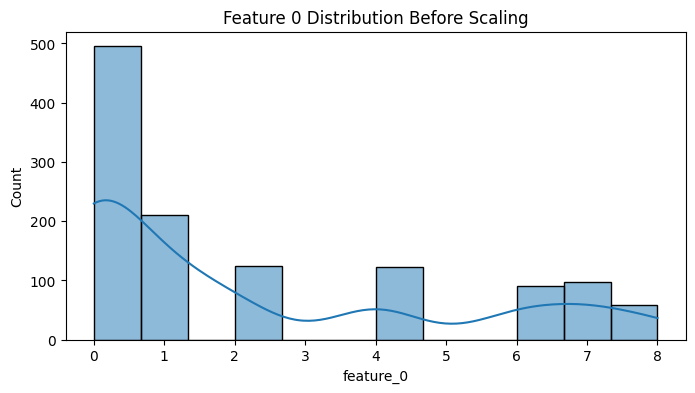

In [ ]:
# Visualize the distribution of a feature before scaling
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

feature_idx = 0  # Index of the feature to visualize
plt.figure(figsize=(8, 4))
sns.histplot(X_df.iloc[:, feature_idx], kde=True)
plt.title(f"Feature {feature_idx} Distribution Before Scaling")
plt.show()

In [39]:
# Preprocess features
X = preprocess_features(X)


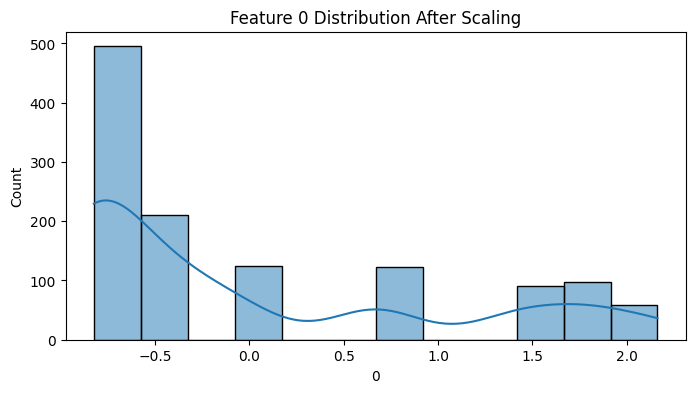

In [ ]:
# Convert scaled features to DataFrame for easier analysis
X_scaled_df = pd.DataFrame(X)

# Visualize the same feature after scaling
plt.figure(figsize=(8, 4))
sns.histplot(X_scaled_df[feature_idx], kde=True)
plt.title(f"Feature {feature_idx} Distribution After Scaling")
plt.show()

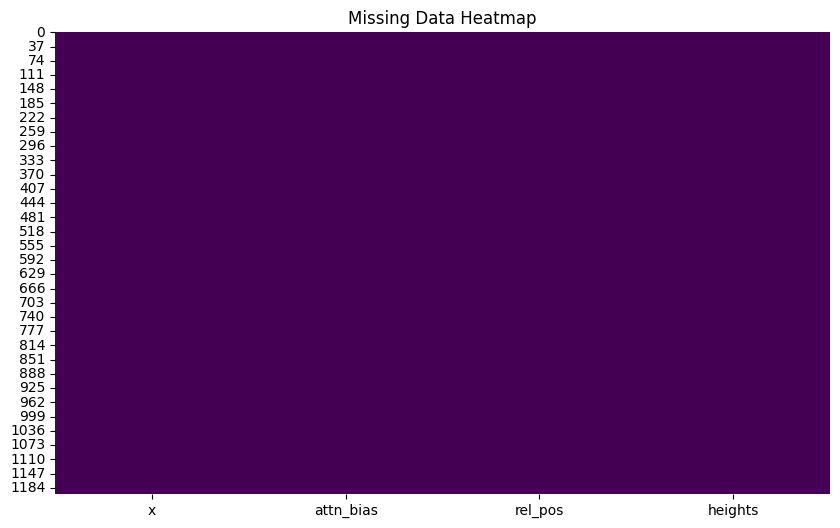

In [ ]:
# Extract the features and labels from your PlanTreeDataset (assuming it's a dataset object with the required data)
features = train_ds.collated_dicts  # If you're working with collated_dicts or modify this to match your features
df_features = pd.DataFrame(features)

# Check for missing values in the features DataFrame
plt.figure(figsize=(10, 6))
sns.heatmap(df_features.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



In [ ]:
# Convert to sets for strict comparison
train_tuples = set(map(tuple, X_train))
test_tuples = set(map(tuple, X_test))

# Find exact intersection (should be 0)
overlap = train_tuples & test_tuples
print(f"New Train-Test Overlap: {len(overlap)}") 

New Train-Test Overlap: 0


In [44]:
print(np.unique(y_train), np.unique(y_test))  # Should differ between training and testing


[0. 1. 2. 4. 6. 7. 8.] [0. 1. 2. 4. 6. 7. 8.]


In [45]:
print(f"Overlap Between Train & Test: {set(y_train) & set(y_test)}")


Overlap Between Train & Test: {0.0, 1.0, 2.0, 4.0, 6.0, 7.0, 8.0}


In [46]:
X_train.size

33552960

In [ ]:
svm_model = train_svm(X_train, y_train)
accuracy, precision, recall = evaluate_model(svm_model, X_test, y_test)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

KeyboardInterrupt: 

In [48]:
# Make predictions
y_pred = svm_model.predict(X_test)

# Compare predictions with actual labels
print("Predictions:", y_pred)
print("Actual Labels:", y_test.values)

# Analyze the prediction distribution
print("Prediction Distribution:", pd.Series(y_pred).value_counts())

Predictions: [1. 4. 8. 1. 0. 1. 2. 1. 8. 0. 2. 0. 0. 1. 4. 1. 0. 7. 7. 4. 1. 0. 0. 0.
 2. 0. 2. 0. 4. 0. 1. 0. 4. 7. 0. 0. 0. 0. 8. 0. 1. 0. 0. 1. 1. 0. 0. 6.
 0. 7. 1. 2. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 6. 0. 0. 1. 6. 4. 0. 0. 0.
 0. 7. 0. 0. 4. 0. 2. 7. 4. 8. 4. 0. 1. 0. 0. 2. 0. 0. 0. 0. 1. 1. 0. 4.
 0. 4. 1. 7. 4. 4. 4. 6. 8. 0. 0. 1. 7. 2. 2. 0. 7. 1. 0. 0. 4. 0. 0. 0.
 7. 0. 1. 1. 6. 1. 1. 6. 0. 7. 1. 2. 2. 0. 0. 6. 4. 6. 0. 0. 6. 7. 0. 7.
 7. 8. 1. 0. 2. 2. 4. 2. 6. 7. 4. 0. 2. 7. 7. 0. 1. 8. 6. 0. 8. 0. 0. 2.
 0. 2. 0. 6. 8. 1. 1. 0. 0. 0. 0. 1. 6. 6. 2. 1. 6. 1. 0. 7. 4. 1. 4. 1.
 0. 7. 1. 8. 0. 0. 4. 0. 4. 4. 0. 4. 0. 2. 8. 0. 0. 1. 0. 0. 6. 0. 0. 0.
 1. 0. 4. 0. 2. 2. 2. 0. 2. 1. 0. 2. 2. 0. 0. 1. 6. 1. 0. 0. 0. 7. 1. 0.
 0.]
Actual Labels: [1. 4. 8. 1. 0. 1. 2. 1. 8. 0. 2. 0. 0. 1. 4. 1. 0. 7. 7. 4. 1. 0. 0. 0.
 2. 0. 2. 0. 4. 0. 1. 0. 4. 7. 0. 0. 6. 0. 8. 0. 1. 0. 0. 1. 1. 0. 0. 6.
 0. 7. 1. 2. 0. 0. 0. 0. 1. 6. 0. 0. 0. 0. 0. 6. 0. 0. 1. 6. 4. 0. 0. 0.
 0. 7. 0. 0. 4. 0.

In [49]:
train_accuracy = svm_model.score(X_train, y_train)
test_accuracy = svm_model.score(X_test, y_test)
print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")


Train Accuracy: 1.00
Test Accuracy: 0.98


In [50]:
# Assuming y_pred contains the predicted knob settings (encoded numerical values)
predicted_knobs = []

for idx in y_pred:
    # Convert the predicted index back to its corresponding knob setting using the encoding mappings
    node_type = encoding.idx2type[idx]
    join_type = encoding.idx2join[idx]
    
    # Combine these knob settings (you can add more as needed)
    knob_setting = {
        'node_type': node_type,
        'join_type': join_type
    }
    predicted_knobs.append(knob_setting)

# Now predicted_knobs contains only the knob settings for each prediction
print(predicted_knobs[:1])  # Display the first 10 predicted knob settings


[{'node_type': 'Hash Join', 'join_type': 'mi_idx.movie_id = t.id'}]


In [51]:
import numpy as np
import torch

# Ensure y_train and y_test are NumPy arrays
if isinstance(y_train, pd.Series):
    y_train = y_train.to_numpy(dtype=int)  # Convert from Pandas to NumPy
else:
    y_train = np.array(y_train, dtype=int)  # Convert if it's not already NumPy

if isinstance(y_test, pd.Series):
    y_test = y_test.to_numpy(dtype=int)
else:
    y_test = np.array(y_test, dtype=int)

In [52]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)


In [53]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(y_test), y=y_pred)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Use in loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)


In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from simpenn import SimpleNN  # Assuming you have a SimpleNN class for the model

# Converts X_train, y_train, X_test, and y_test (assumed to be NumPy arrays or Pandas DataFrames) into PyTorch tensors.
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


# Combines input (X_train_tensor) and labels (y_train_tensor) into a dataset.
# Create DataLoader for batching
# groups 64 samples at a time).
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
num_classes = max(y_train.max(), y_test.max()) + 1 
# Initialize the model, loss function, and optimizer
model = SimpleNN(input_size=X_train.shape[1], hidden_size=128, num_classes=num_classes)
# nn.CrossEntropyLoss() → Suitable for multi-class classific
criterion = nn.CrossEntropyLoss()
# Adaptive learning rate for better convergence.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
    
        optimizer.zero_grad()  # Zero the gradients: Clears previous gradients to prevent accumulation.
        outputs = model(inputs)  # Forward pass: Computes predictions using model(inputs).
        loss = criterion(outputs, labels)  # Calculate loss: Compares predictions with actual labels.
        loss.backward()  # Backward pass: Calculates gradients using loss.backward().
        optimizer.step()  # Update weights : Updates model weights based on gradients.

        epoch_loss += loss.item() * inputs.size(0)  # Accumulate loss: ## Sum loss for all samples
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()  # Track correct predictions :# Count correct predictions
        total += labels.size(0)

    # Calculate average loss and accuracy for the epoch
    avg_loss = epoch_loss / total  
    accuracy = correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    # Optionally, print the loss and accuracy for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy*100:.2f}%')

# Evaluate the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == y_test_tensor).sum().item()
    accuracy = correct / y_test_tensor.size(0)

    print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch [1/50], Loss: 0.5509, Accuracy: 86.87%
Epoch [2/50], Loss: 0.1438, Accuracy: 96.32%
Epoch [3/50], Loss: 0.0880, Accuracy: 97.98%
Epoch [4/50], Loss: 0.0414, Accuracy: 98.48%
Epoch [5/50], Loss: 0.0312, Accuracy: 98.77%
Epoch [6/50], Loss: 0.0161, Accuracy: 99.49%
Epoch [7/50], Loss: 0.0236, Accuracy: 99.39%
Epoch [8/50], Loss: 0.0265, Accuracy: 99.39%
Epoch [9/50], Loss: 0.0116, Accuracy: 99.75%
Epoch [10/50], Loss: 0.0084, Accuracy: 99.86%
Epoch [11/50], Loss: 0.0099, Accuracy: 99.78%
Epoch [12/50], Loss: 0.0063, Accuracy: 99.89%
Epoch [13/50], Loss: 0.0028, Accuracy: 99.89%
Epoch [14/50], Loss: 0.0035, Accuracy: 99.93%
Epoch [15/50], Loss: 0.0031, Accuracy: 99.93%
Epoch [16/50], Loss: 0.0039, Accuracy: 99.93%
Epoch [17/50], Loss: 0.0104, Accuracy: 99.71%
Epoch [18/50], Loss: 0.0804, Accuracy: 98.48%
Epoch [19/50], Loss: 0.0232, Accuracy: 99.06%
Epoch [20/50], Loss: 0.0203, Accuracy: 99.53%
Epoch [21/50], Loss: 0.0184, Accuracy: 99.53%
Epoch [22/50], Loss: 0.0080, Accuracy: 99.6

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch

# Assuming y_test_tensor and predicted are available from the evaluation step in the code
y_true = y_test_tensor.numpy()  # Convert PyTorch tensor to NumPy array
y_pred = predicted.numpy()  # Convert PyTorch tensor to NumPy array

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Accuracy: 0.96
Precision: 0.96
Recall: 0.96
F1-Score: 0.96


In [56]:

# Compare predictions with actual labels
print("Predictions:", y_pred)
print("Actual Labels:", y_test)

# Analyze the prediction distribution
print("Prediction Distribution:", pd.Series(y_pred).value_counts())

Predictions: [1 4 8 1 0 1 2 1 8 0 2 0 0 1 4 1 0 7 7 4 1 0 0 0 2 0 2 0 4 0 1 0 4 7 0 0 0
 0 8 0 1 0 0 1 1 0 0 6 0 7 1 2 0 0 0 0 1 0 0 0 0 0 0 6 0 0 1 6 4 0 0 0 0 7
 0 0 4 0 2 2 4 8 4 0 1 0 0 2 0 0 0 0 1 1 0 4 0 4 1 7 4 4 4 0 8 0 0 1 7 2 2
 0 7 0 0 0 4 0 0 0 7 0 1 1 6 1 1 6 0 7 1 2 2 0 0 6 4 6 0 0 6 7 0 7 7 8 1 0
 2 2 4 2 0 7 4 0 2 7 7 0 1 8 0 0 8 0 0 7 0 2 0 6 8 1 1 0 0 0 0 1 6 6 2 1 6
 1 0 7 4 1 4 1 0 7 1 8 0 0 4 0 4 4 0 4 0 2 8 0 0 1 0 0 6 0 0 0 1 0 4 0 2 2
 2 0 2 1 0 2 2 0 0 1 6 1 0 0 0 7 1 0 0]
Actual Labels: [1 4 8 1 0 1 2 1 8 0 2 0 0 1 4 1 0 7 7 4 1 0 0 0 2 0 2 0 4 0 1 0 4 7 0 0 6
 0 8 0 1 0 0 1 1 0 0 6 0 7 1 2 0 0 0 0 1 6 0 0 0 0 0 6 0 0 1 6 4 0 0 0 0 7
 0 0 4 0 2 7 4 8 4 0 1 0 0 2 0 0 0 0 1 1 0 4 0 4 1 7 4 4 4 6 8 0 0 1 7 2 2
 0 7 1 0 0 4 0 0 0 7 0 1 1 6 1 1 6 0 7 1 2 2 0 0 6 4 6 0 0 6 7 0 7 7 8 1 0
 2 2 4 2 6 7 4 0 2 7 7 0 1 8 6 0 8 0 0 2 0 2 0 6 8 1 1 0 0 0 0 1 8 6 2 1 6
 1 0 7 4 1 4 1 0 7 1 8 0 0 4 0 4 4 0 4 0 2 8 0 0 1 0 0 6 0 0 0 1 0 4 0 2 2
 2 1 2 1 0 2 2 0 0 1 6 1 0 0 0 7

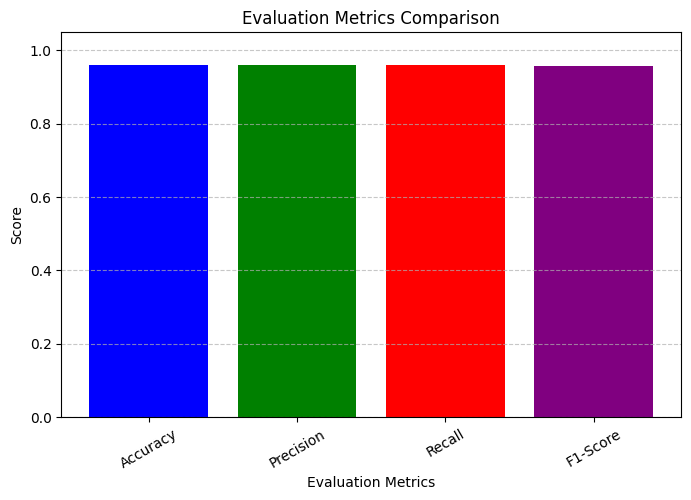

In [57]:
import matplotlib.pyplot as plt

# Define the evaluation metrics
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [accuracy, precision, recall, f1]  # Given metrics

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.ylim(0, 1.05)  # Set y-axis range from 0 to 1
plt.xlabel("Evaluation Metrics")
plt.ylabel("Score")
plt.title("Evaluation Metrics Comparison")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


In [58]:
model.eval()  # Set the model to evaluation mode
predicted_knobs = []
true_knobs = []

with torch.no_grad():
    outputs = model(X_test_tensor)  # Get model predictions
    _, predicted = torch.max(outputs, 1)  # Convert logits to class indices
    
    # Convert tensors to lists for easier comparison
    predicted = predicted.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()

    # Extract knob settings using encoding mappings
    for pred_idx, true_idx in zip(predicted, y_test_np):
        predicted_knobs.append(encoding.idx2type.get(pred_idx, "Unknown"))  # Model-predicted knob
        true_knobs.append(encoding.idx2type.get(true_idx, "Unknown"))  # True knob setting

# Print first 10 predictions for verification
for i in range(10):
    print(f"Sample {i+1}:")
    print(f"  True Knob: {true_knobs[i]}")
    print(f"  Predicted Knob: {predicted_knobs[i]}")
    print("-" * 40)


Sample 1:
  True Knob: Hash Join
  Predicted Knob: Hash Join
----------------------------------------
Sample 2:
  True Knob: Bitmap Heap Scan
  Predicted Knob: Bitmap Heap Scan
----------------------------------------
Sample 3:
  True Knob: Merge Join
  Predicted Knob: Merge Join
----------------------------------------
Sample 4:
  True Knob: Hash Join
  Predicted Knob: Hash Join
----------------------------------------
Sample 5:
  True Knob: Gather
  Predicted Knob: Gather
----------------------------------------
Sample 6:
  True Knob: Hash Join
  Predicted Knob: Hash Join
----------------------------------------
Sample 7:
  True Knob: Seq Scan
  Predicted Knob: Seq Scan
----------------------------------------
Sample 8:
  True Knob: Hash Join
  Predicted Knob: Hash Join
----------------------------------------
Sample 9:
  True Knob: Merge Join
  Predicted Knob: Merge Join
----------------------------------------
Sample 10:
  True Knob: Gather
  Predicted Knob: Gather
----------------

In [59]:
for i in range(len(true_knobs)):
    if true_knobs[i] != predicted_knobs[i]:  # Find errors
        print(f"Sample {i+1}: ❌ Mismatch")
        print(f"  True Knob: {true_knobs[i]}")
        print(f"  Predicted Knob: {predicted_knobs[i]}")
        print("-" * 40)


Sample 37: ❌ Mismatch
  True Knob: Nested Loop
  Predicted Knob: Gather
----------------------------------------
Sample 58: ❌ Mismatch
  True Knob: Nested Loop
  Predicted Knob: Gather
----------------------------------------
Sample 80: ❌ Mismatch
  True Knob: Index Scan
  Predicted Knob: Seq Scan
----------------------------------------
Sample 104: ❌ Mismatch
  True Knob: Nested Loop
  Predicted Knob: Gather
----------------------------------------
Sample 114: ❌ Mismatch
  True Knob: Hash Join
  Predicted Knob: Gather
----------------------------------------
Sample 153: ❌ Mismatch
  True Knob: Nested Loop
  Predicted Knob: Gather
----------------------------------------
Sample 163: ❌ Mismatch
  True Knob: Nested Loop
  Predicted Knob: Gather
----------------------------------------
Sample 168: ❌ Mismatch
  True Knob: Seq Scan
  Predicted Knob: Index Scan
----------------------------------------
Sample 181: ❌ Mismatch
  True Knob: Merge Join
  Predicted Knob: Nested Loop
--------------

In [60]:
predicted_knobs = []

# Assuming y_pred contains the predicted indices for knob settings (like 'Hash Join', 'Seq Scan', etc.)
for idx in y_pred:
    # Convert the predicted index back to its corresponding knob setting (node type) using the encoding mappings
    node_type = encoding.idx2type[idx]
    predicted_knobs.append(node_type)

# Now predicted_knobs contains only the decoded knob settings for each prediction
print(predicted_knobs[:1])  # Display the first 10 predictions to check


['Hash Join']


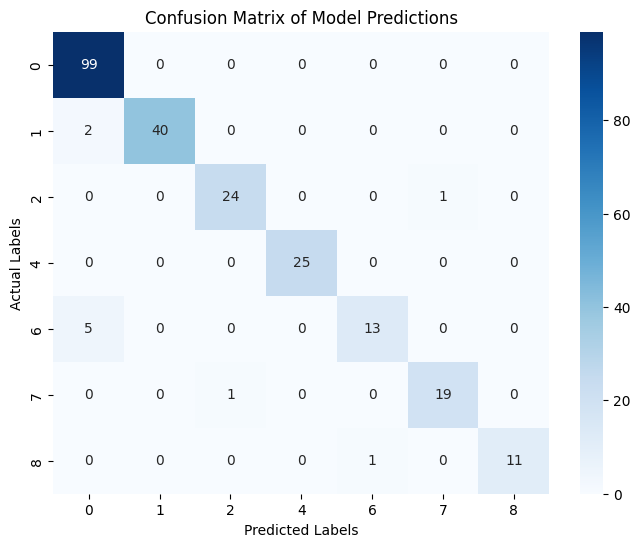

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_pred)))
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix of Model Predictions")
plt.show()


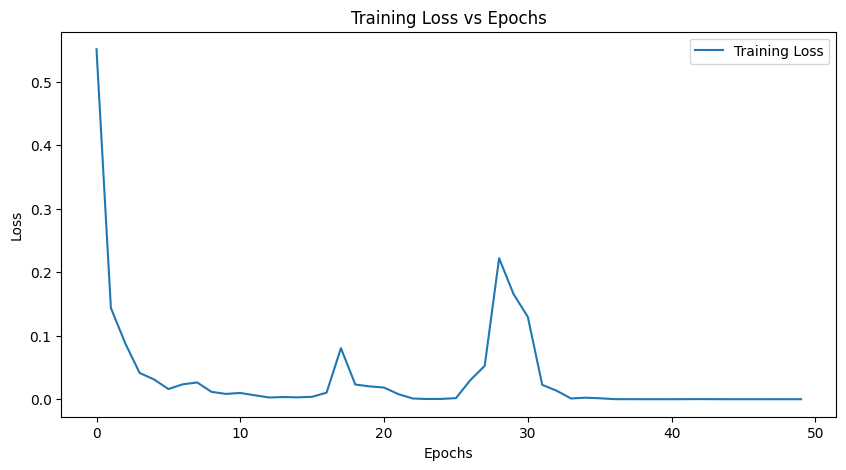

In [62]:
# After training, plot the loss curve
# Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.legend()
plt.show()


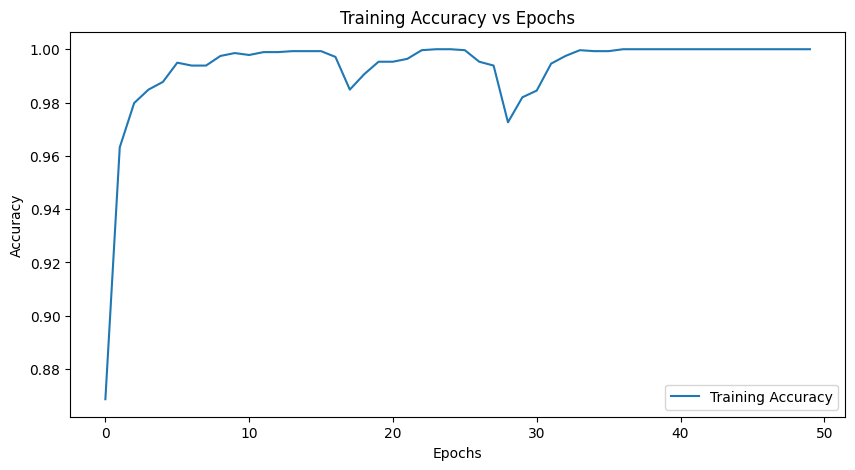

In [63]:
# Plot Training Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Epochs')
plt.legend()
plt.show()